In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize
from scipy.optimize import curve_fit, differential_evolution

# import cupy as cp

In [2]:
t_min = 0
t_end = 24 * 5

In [3]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
data = np.cumsum(data, axis=0)

mean_srip_data = np.mean(data, axis=1)  # 各時間点での平均値
std_srip_data = np.std(data, axis=1)  # 各時間点での標準偏差

t_data = np.array([24*i for i in range(6)])

# 実験データのパラメータを使って収量を最大化する

In [ ]:
K_ser=5.4e-06
k_sRNA=3.3e-04
k_dRNA=2.3e-02
k_vp=4.9e-02
K_RNA=8.8e+03
k_t=6.6e-02

In [23]:
params_fix = [
    # P,            K_ser,   k_DNA,          k_sRNA,  k_dRNA,  k_vp,    K_RNA,   k_t,     RNA_0, SRIP_0
    [math.log(2)/24, 5.4e-6, math.log(2)/24, 3.3e-04, 2.3e-02, 4.9e-02, 8.8e+03, 6.6e-02, 0.0,   0.0]
    ]

P, K_ser, k_DNA, k_sRNA, k_dRNA, k_vp, K_RNA, k_t, RNA_0, SRIP_0 = params_fix[0]

def model_for_improve(t, y, X_max, Ser):
    X, DNA, RNA, SRIP = y
    if X < 0:
        X = 0
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_sRNA * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

def objective(params):
    X_max, Ser, X_0, DNA_0 = params
    y0 = [X_0, DNA_0 / X_0 * 0.8, 0.0, 0.0] 
    T = 80
    t_span = [0, T]
    result = solve_ivp(model_for_improve, t_span, y0, args=(X_max, Ser), t_eval=[T])
    return -result.y[3][-1]

# 初期推定値
initial_param = [
    #X_max, Ser,    X_0,   DNA_0
    [1.3e7, 9.5e-3, 1.3e7, 2.0e12],
    [1.3e6, 4.0e-4, 2.0e5, 2.0e11],
    [1.3e7, 4.0e-4, 1.3e7, 2.0e12]
    ]


index = 2
X_max, Ser, X_0, DNA_0 = initial_param[index]
bounds = [(0, X_max), (0, Ser), (0, X_max), (0, DNA_0)]

# DNA_0 = DNA_0 / X_0 * 0.8
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

result = minimize(objective, initial_param[index], bounds=bounds)

print(result.x)  # 最適化されたパラメータ値

[1.30000000e+07 4.00000000e-04 1.29999972e+07 2.00000000e+12]


最適化されたパラメータ(full): [1.30000000e+07 4.00000000e-04 1.29999972e+07 2.00000000e+12]


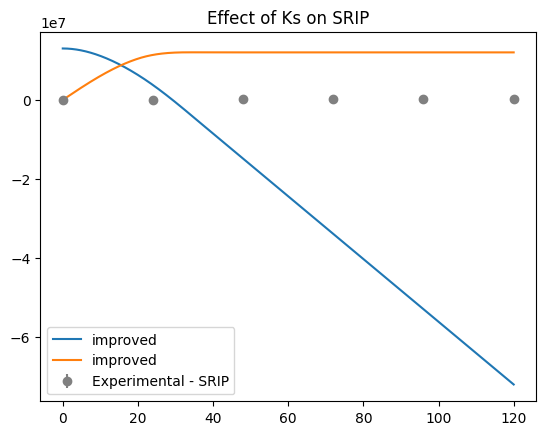

In [25]:
print('最適化されたパラメータ(full):', result.x)

P, K_ser, k_DNA, k_sRNA, k_dRNA, k_vp, K_RNA, k_t, RNA_0, SRIP_0 = params_fix[0]
X_max, Ser, X_0, DNA_0 = result.x
y0 = [X_0, DNA_0, RNA_0, SRIP_0]
sol = solve_ivp(model_for_improve, [t_min, t_end], y0, args=(X_max, Ser), t_eval=np.linspace(t_min, t_end, 1000), method='RK45')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sol.t, sol.y[0], label=f'improved')
ax.plot(sol.t, sol.y[3], label=f'improved')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of Ks on SRIP')
# ax.set_ylim(0, 5e5)
ax.legend()